In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error

# 4 ARIMA(0,1,2)

In [3]:
df4 = pd.read_csv('/content/drive/MyDrive/BK21/data/widget_sales.csv')
df4.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


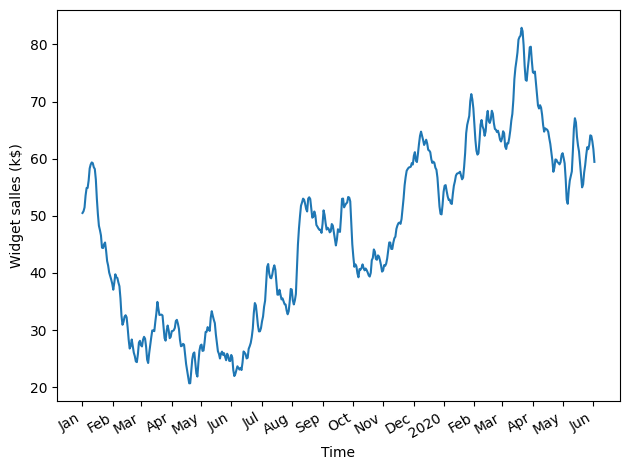

In [4]:
fig, ax = plt.subplots()

ax.plot(df4['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget salles (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec',
     '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [5]:
# adf 테스트

ADF_result = adfuller(df4['widget_sales'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.5121662069358996
p-value: 0.5274845352272631


In [6]:
widget_sales_diff = np.diff(df4['widget_sales'], n = 1)

In [7]:
ADF_result = adfuller(widget_sales_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -10.576657780341957
p-value: 7.076922818587346e-19


In [8]:
train = df4[:int(0.9*len(df4))]
test = df4[int(0.9*len(df4)):]

print(len(train))
print(len(test))

450
50


In [9]:
# ARIMA

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

  results = []

  for order in tqdm(order_list):
    try:
      model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
    except:
      continue

    aic = model.aic
    results.append([order, aic])

  result_df = pd.DataFrame(results)
  result_df.columns = ['(p,q)', 'AIC']

  result_df = result_df.sort_values(by = 'AIC', ascending = True).reset_index(drop = True)

  return result_df

In [10]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list  = list(product(ps, qs))

In [11]:
result_df = optimize_ARIMA(train, order_list, d)
result_df
# 0,1,2보다 3,1,3이 더 적합

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(3, 3)",1251.432524
1,"(0, 2)",1254.409302
2,"(2, 1)",1254.961827
3,"(0, 3)",1255.826822
4,"(3, 0)",1255.967595
5,"(1, 2)",1255.982548
6,"(1, 1)",1256.284513
7,"(3, 1)",1256.850863
8,"(2, 2)",1256.918179
9,"(1, 3)",1257.643259


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


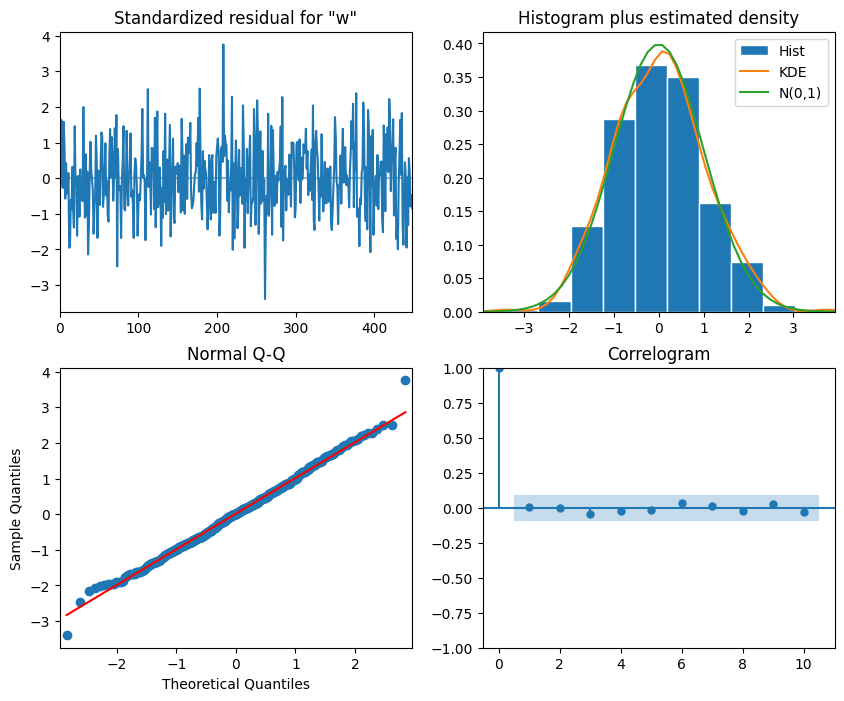

In [12]:
model = SARIMAX(train, order=(3,1,3), simple_differencing=False)
model_fit = model.fit(disp=False)

# Q-Q 도식
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

In [13]:
# 융-박스 테스트
residuals = model_fit.resid
pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue["lb_pvalue"].to_numpy())

[0.89397633 0.97766108 0.97058208 0.99203802 0.99793291 0.99438584
 0.99714051 0.99878755 0.99953746 0.99982493]


In [14]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

  total_len = train_len + horizon

  # 평균값
  if method == 'mean':
    pred_mean = []

    for i in range(train_len, total_len, window):
      mean = np.mean(df[:i])
      pred_mean.extend(mean for _ in range(window))

    return pred_mean

  # 마지막 값
  elif method == 'last':
    pred_last_value = []

    for i in range(train_len, total_len, window):
      last_value = df[:i].iloc[-1].values[0]
      pred_last_value.extend(last_value for _ in range(window))

    return pred_last_value

  # ARIMA
  elif method == 'ARIMA':
    pred_ARIMA = []

    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i], order=(3,1,3))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]
      pred_ARIMA.extend(oos_pred)

    return pred_ARIMA

In [15]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(pred_df)
WINDOW = 2

pred_mean = rolling_forecast(df4, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last = rolling_forecast(df4, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df4, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

pred_df.loc[:, 'pred_mean'] = pred_mean
pred_df.loc[:, 'pred_last'] = pred_last
pred_df.loc[:, 'pred_ARIMA'] = pred_ARIMA

pred_df.head()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

,widget_sales,pred_mean,pred_last,pred_ARIMA
450,64.736005,45.472231,65.906136,64.811120
451,65.316972,45.472231,65.906136,64.717807
452,65.172070,45.558754,65.316972,66.240421
453,65.075506,45.558754,65.316972,66.603975
454,64.703173,45.644943,65.075506,64.994040


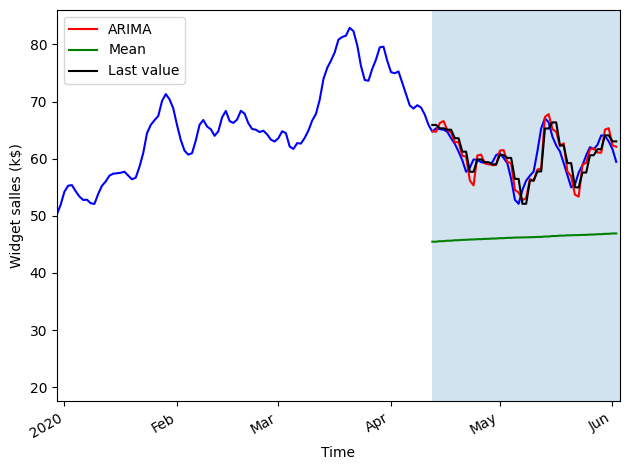

In [16]:
fig, ax = plt.subplots()

ax.plot(df4['widget_sales'], 'b-')
ax.plot(range(450, 500), pred_df['pred_ARIMA'], 'r-', label='ARIMA')
ax.plot(range(450, 500), pred_df['pred_mean'], 'g-', label='Mean')
ax.plot(range(450, 500), pred_df['pred_last'], 'k-', label='Last value')

plt.xlim(350, 500)
ax.set_xlabel('Time')
ax.set_ylabel('Widget salles (k$)')

plt.xticks(
    [352, 382, 409, 439, 468, 498],
    ['2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

ax.axvspan(len(train), len(train) + len(test), alpha=0.2)
ax.legend()

fig.autofmt_xdate()
plt.tight_layout()

In [17]:
mae_mean = mean_absolute_error(pred_df['widget_sales'], pred_df['pred_mean'])
mae_last = mean_absolute_error(pred_df['widget_sales'], pred_df['pred_last'])
mae_ARIMA = mean_absolute_error(pred_df['widget_sales'], pred_df['pred_ARIMA'])

#기존 MA(2)는 1.95
print(mae_mean, mae_last, mae_ARIMA)

14.220336729946744 1.819226540180243 1.5736059917821787


# 5 ARIMA(3,1,0)

In [18]:
df5 = pd.read_csv('/content/drive/MyDrive/BK21/data/foot_traffic.csv')
df5.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


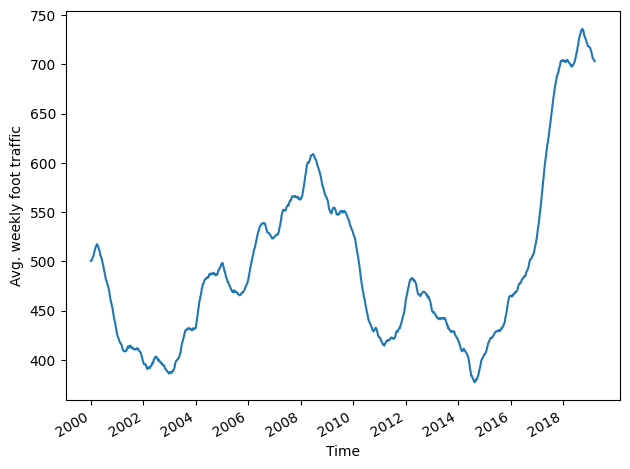

In [19]:
fig, ax = plt.subplots()

ax.plot(df5['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Avg. weekly foot traffic')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

In [20]:
ADF_result = adfuller(df5['foot_traffic'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.1758885999240682
p-value: 0.6838808917896216


In [21]:
foot_traffic_diff = np.diff(df5['foot_traffic'], n = 1)

In [22]:
ADF_result = adfuller(foot_traffic_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -5.2682313474220495
p-value: 6.3693176547810965e-06


In [23]:
train = df5[:-52]
test = df5[-52:]

print(len(train))
print(len(test))

948
52


In [24]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))

In [25]:
result_df = optimize_ARIMA(train, order_list, d)
result_df
# 3,1,0보다 1,1,3이 더 적합

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)",AIC
0,"(1, 3)",2658.013441
1,"(3, 1)",2658.595081
2,"(3, 0)",2658.691777
3,"(2, 1)",2659.873751
4,"(3, 2)",2659.916852
5,"(2, 3)",2659.977855
6,"(3, 3)",2660.802093
7,"(2, 2)",2661.229924
8,"(2, 0)",2667.725827
9,"(1, 2)",2669.719835


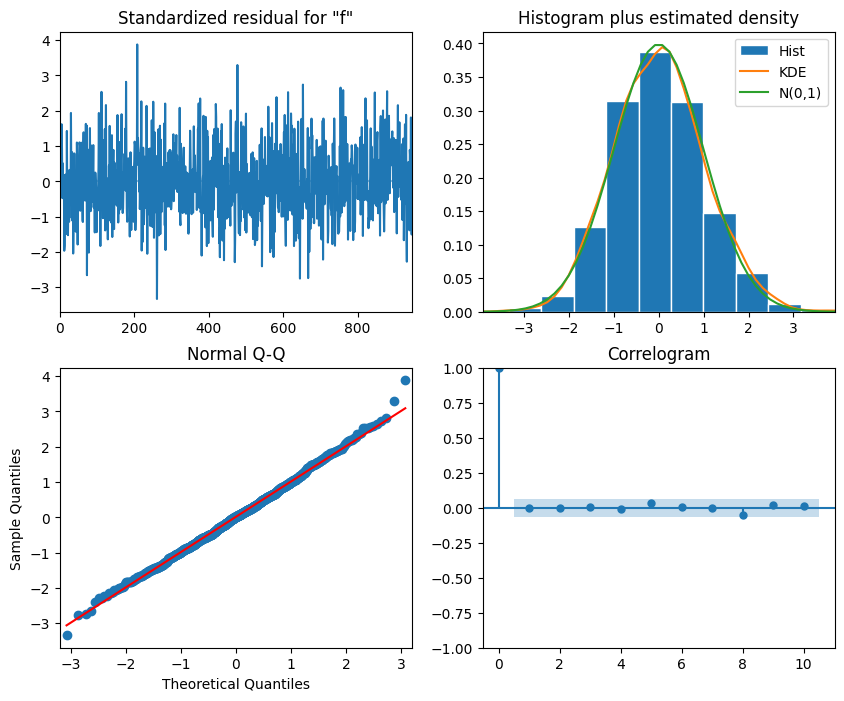

In [26]:
model = SARIMAX(train, order=(1,1,3), simple_differencing=False)
model_fit = model.fit(disp=False)

# Q-Q 도식
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

In [27]:
# 융-박스 테스트
residuals = model_fit.resid
pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue["lb_pvalue"].to_numpy())

[0.99973565 0.99860149 0.99967645 0.99998311 0.9999992  0.9999998
 0.99999998 1.         1.         1.        ]


In [28]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

  total_len = train_len + horizon

  # 평균값
  if method == 'mean':
    pred_mean = []

    for i in range(train_len, total_len, window):
      mean = np.mean(df[:i])
      pred_mean.extend(mean for _ in range(window))

    return pred_mean

  # 마지막 값
  elif method == 'last':
    pred_last_value = []

    for i in range(train_len, total_len, window):
      last_value = df[:i].iloc[-1].values[0]
      pred_last_value.extend(last_value for _ in range(window))

    return pred_last_value

  # ARIMA
  elif method == 'ARIMA':
    pred_ARIMA = []

    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i], order=(3,1,0))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]
      pred_ARIMA.extend(oos_pred)

    return pred_ARIMA

In [29]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(pred_df)
WINDOW = 2

pred_mean = rolling_forecast(df5, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last = rolling_forecast(df5, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df5, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

pred_df.loc[:, 'pred_mean'] = pred_mean
pred_df.loc[:, 'pred_last'] = pred_last
pred_df.loc[:, 'pred_ARIMA'] = pred_ARIMA

pred_df.head()

,foot_traffic,pred_mean,pred_last,pred_ARIMA
948,701.686830,481.204906,702.463430,701.743717
949,701.112198,481.204906,702.463430,700.947192
950,700.221501,481.668474,701.112198,700.447460
951,699.937948,481.668474,701.112198,699.877562
952,698.107264,482.127321,699.937948,699.358669


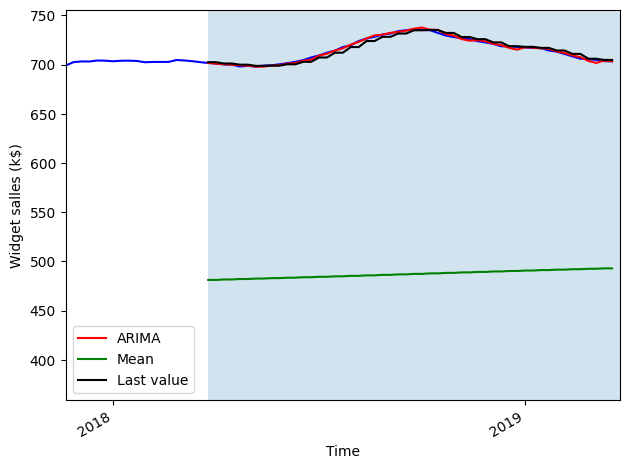

In [30]:
fig, ax = plt.subplots()

ax.plot(df5['foot_traffic'], 'b-')
ax.plot(pred_df['pred_ARIMA'], 'r-', label='ARIMA')
ax.plot(pred_df['pred_mean'], 'g-', label='Mean')
ax.plot(pred_df['pred_last'], 'k-', label='Last value')

plt.xlim(930, 1000)
ax.set_xlabel('Time')
ax.set_ylabel('Widget salles (k$)')

plt.xticks(
    [936, 988],
    [2018, 2019])

ax.axvspan(len(train), len(train) + len(test), alpha=0.2)
ax.legend()

fig.autofmt_xdate()
plt.tight_layout()

In [31]:
mae_mean = mean_absolute_error(pred_df['foot_traffic'], pred_df['pred_mean'])
mae_last = mean_absolute_error(pred_df['foot_traffic'], pred_df['pred_last'])
mae_ARIMA = mean_absolute_error(pred_df['foot_traffic'], pred_df['pred_ARIMA'])

#기존 AR(3)는 3.47
print(mae_mean, mae_last, mae_ARIMA)

228.051958527739 2.0698682705816465 0.9255106861096115


# 6 ARIMA(2,1,2)

In [32]:
df6 = pd.read_csv('/content/drive/MyDrive/BK21/data/bandwidth.csv')
df6.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


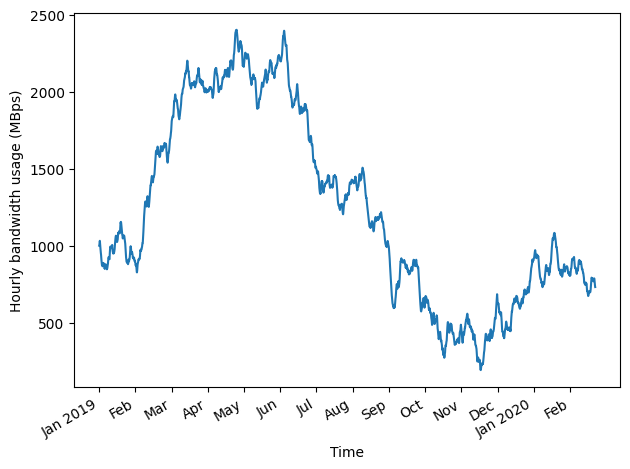

In [33]:
fig, ax = plt.subplots()

ax.plot(df6['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth usage (MBps)')

plt.xticks(
    np.arange(0, 10000, 730),
           ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec',
            'Jan 2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [34]:
ADF_result = adfuller(df6['hourly_bandwidth'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.8714653199452762
p-value: 0.7972240255014542


In [35]:
hourly_bandwidth_diff = np.diff(df6['hourly_bandwidth'], n = 1)

In [36]:
ADF_result = adfuller(hourly_bandwidth_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -20.694853863789017
p-value: 0.0


In [37]:
train = df6[:-168]
test = df6[-168:]

print(len(train))
print(len(test))

9832
168


In [38]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))

In [39]:
result_df = optimize_ARIMA(train, order_list, d)
result_df
# 2,1,2보다 3,1,2가 더 적합

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)",AIC
0,"(3, 2)",27991.063157
1,"(2, 3)",27991.286794
2,"(2, 2)",27991.602936
3,"(3, 3)",27993.416226
4,"(1, 3)",28003.348864
5,"(1, 2)",28051.350913
6,"(3, 1)",28071.155049
7,"(3, 0)",28095.617602
8,"(2, 1)",28097.250206
9,"(2, 0)",28098.407146


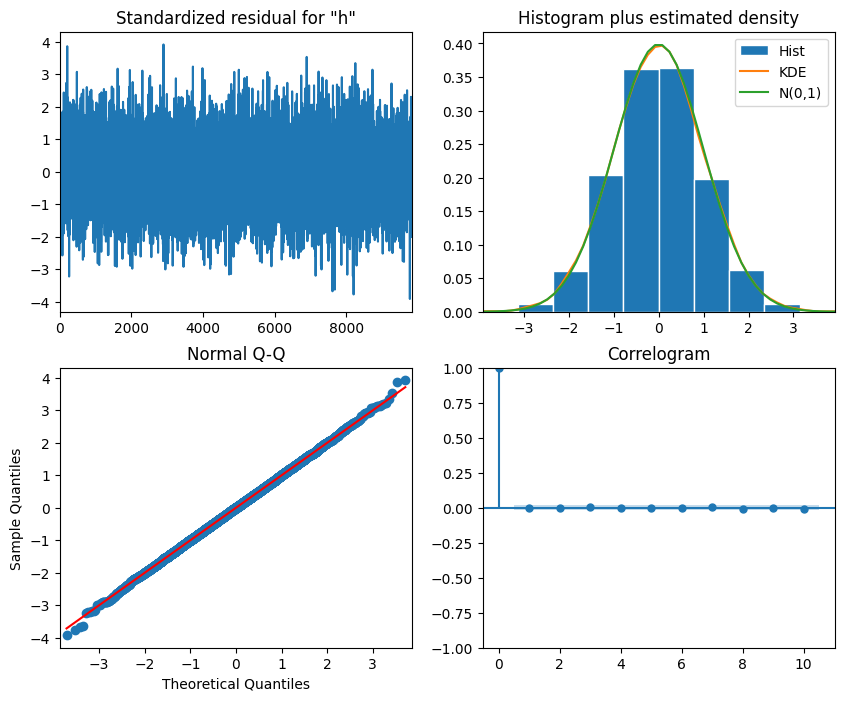

In [40]:
model = SARIMAX(train, order=(3,1,2), simple_differencing=False)
model_fit = model.fit(disp=False)

# Q-Q 도식
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

In [41]:
# 융-박스 테스트
residuals = model_fit.resid
pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue["lb_pvalue"].to_numpy())

[0.96320603 0.99690227 0.99873527 0.99989835 0.99999212 0.99999689
 0.99999961 0.99999996 1.         1.        ]


In [42]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

  total_len = train_len + horizon

  # 평균값
  if method == 'mean':
    pred_mean = []

    for i in range(train_len, total_len, window):
      mean = np.mean(df[:i])
      pred_mean.extend(mean for _ in range(window))

    return pred_mean

  # 마지막 값
  elif method == 'last':
    pred_last_value = []

    for i in range(train_len, total_len, window):
      last_value = df[:i].iloc[-1].values[0]
      pred_last_value.extend(last_value for _ in range(window))

    return pred_last_value

  # ARIMA
  elif method == 'ARIMA':
    pred_ARIMA = []

    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i], order=(3,1,2))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]
      pred_ARIMA.extend(oos_pred)

    return pred_ARIMA

In [43]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df6, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last = rolling_forecast(df6, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df6, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

pred_df.loc[:, 'pred_mean'] = pred_mean
pred_df.loc[:, 'pred_last'] = pred_last
pred_df.loc[:, 'pred_ARIMA'] = pred_ARIMA

pred_df.head()

,hourly_bandwidth,pred_mean,pred_last,pred_ARIMA
9832,717.176939,1241.072644,723.120934,717.667463
9833,711.311745,1241.072644,723.120934,712.785142
9834,708.114679,1240.965500,711.311745,705.964113
9835,707.024482,1240.965500,711.311745,701.190237
9836,707.689774,1240.857042,707.024482,706.616532


In [44]:
mae_mean = mean_absolute_error(pred_df['hourly_bandwidth'], pred_df['pred_mean'])
mae_last = mean_absolute_error(pred_df['hourly_bandwidth'], pred_df['pred_last'])
mae_ARIMA = mean_absolute_error(pred_df['hourly_bandwidth'], pred_df['pred_ARIMA'])

#기존 ARMA(2,2)는 14
print(mae_mean, mae_last, mae_ARIMA)

497.927419811828 2.8444991498767638 1.3837987535864709
